## Random forest

Random forest is a statistical method used to build a classification model. With this model, one can describe how the values of the target variable is obtained based on the values of the feature variables. Random forest is an ensemble model, which means that is actually built up by numerous base models, and the predicted values are obtained considering prediction from each base model. In this case the base models are decision trees. Each tree is built using random sampling (with replacement) from the sample, and using randomly selected features. 

In the following, the 'Heart Failure Prediction Dataset' is used from kaggle.com : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

The aim is to describe and predict occurrence of heart failure (=target variable) based on different attributes of the person (=features). 

<a id='section1'></a>

### <ins>Data preparation<ins> 
The details of data preparation can be found at LINK TO DEC TREE, here only the code is provided:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv(
    "https://raw.githubusercontent.com/MMateo1120/machine_learning_tutorials/main/heart.csv"
)

features = data.columns[:-1]
target = data.columns[-1]

X = data[features]
y = data[target].to_frame()

# drop rows where cholesterol is outlier:
y = y.loc[X["Cholesterol"] > 0].reset_index(drop=True)
X = X.loc[X["Cholesterol"] > 0].reindex().reset_index(drop=True)

# finding features that are categorical based on the coding of their values:
categorical = []
for column in X.columns:
    if isinstance(X[column][0], str):
        categorical.append(column)
        
# transformation of categorical features:
X["Sex"] = X["Sex"].map({"M": 0, "F": 1})
X["ExerciseAngina"] = X["ExerciseAngina"].map({"N": 0, "Y": 1})

categorical.remove("Sex")
categorical.remove("ExerciseAngina")

onehot_encoder = OneHotEncoder(sparse_output=False)

for column in categorical:
    wide = onehot_encoder.fit_transform(X[column].to_frame())
    wide_df = pd.DataFrame(
        wide, columns=onehot_encoder.get_feature_names_out([column])
    )
    X = X.drop(columns=column)
    X = pd.concat([X, wide_df], axis=1)
    
# y is required to be an array:
y = y.iloc[:,0]

<br/>   <a id='section2'></a>

### <ins>Data evaluation I. : Fitting random forest without tuning the hyperparameters

Generally random forest models are less prune to overfit, and thus may be efficient even without hyperparameter tuning in prediction of unseen datasets. Let's check how well untuned models can predict test sets:

In [5]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scores = []

np.random.seed(111)

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = RandomForestClassifier(random_state=111)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

The distribution of the predictive accuracy of unseen test sets:

(array([ 1.,  1.,  6.,  8., 10., 18., 18., 21., 14.,  3.]),
 array([0.78666667, 0.8       , 0.81333333, 0.82666667, 0.84      ,
        0.85333333, 0.86666667, 0.88      , 0.89333333, 0.90666667,
        0.92      ]),
 <BarContainer object of 10 artists>)

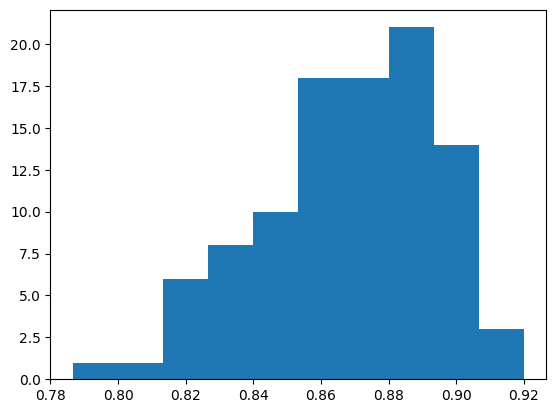

In [53]:
plt.hist(scores)

The statsitics of the predictive accuracy for unseen test sets:

In [54]:
print(f"The mean accuracy: {np.mean(scores)}"
      + "\n"
      + f"The standard deviation: {np.std(scores)}")

The mean accuracy: 0.8656
The standard deviation: 0.02674521764104131


The untuned random forest model performs better than a single decision tree, which had mean predictive accuracy of 0.83.

<br/>   <a id='section2'></a>

### <ins>Data evaluation II. : Tuning hyperparameters using repeated cross-validation

Now let's tune the hyperparameters of the model using repeated cross-validation:

In [6]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# suppress warnings from numpy:
np.seterr(all="ignore")

param_grid = {
    "n_estimators": [1, 10, 50, 100, 200, 300],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [1, 3, 5, 8, 15],
    "min_samples_leaf": [1, 2, 4, 10, 30],
}

clf = RandomForestClassifier(random_state=111)
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=111)
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=cv, n_jobs=-1
)
grid_search.fit(X, y)
print(f"The best hyperparameters are: {grid_search.best_params_}")
print(f"The best score is: {grid_search.best_score_}")

KeyboardInterrupt: 

We obtained practically the same accuracy as with the untuned random forrest model. Let's see the distribution of the predictive accuracy when different part of the dataset is used as test sets:

(array([  5.,  18.,  31.,  90.,  91.,  99., 112.,  34.,  14.,   6.]),
 array([0.78666667, 0.802     , 0.81733333, 0.83266667, 0.848     ,
        0.86333333, 0.87866667, 0.894     , 0.90933333, 0.92466667,
        0.94      ]),
 <BarContainer object of 10 artists>)

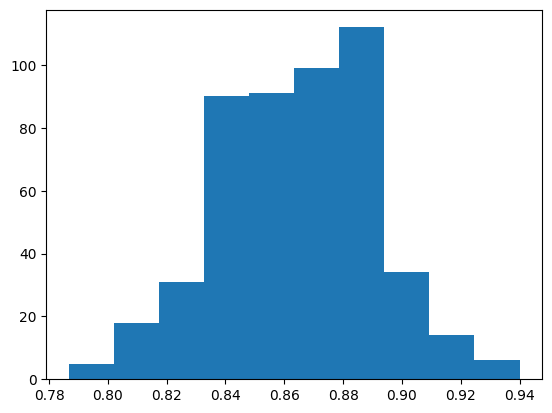

In [38]:
scores = []


clf = RandomForestClassifier(random_state=111, max_depth=8, max_features='sqrt',n_estimators=200)

for _ in range(500):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.hist(scores)

The statsitics of the predictive accuracy for the test sets in cross-validation:

In [39]:
print(f"The mean accuracy: {np.mean(scores)}"
      + "\n"
      + f"The standard deviation: {np.std(scores)}")

The mean accuracy: 0.8641866666666668
The standard deviation: 0.027042038056001295


The results are practically the same as they were for the untuned.

<br/>   <a id='section2'></a>

### <ins>Data evaluation III. : Checking the uncertainity introduced by both the training process and test set prediction using repeated nested cross-validation

The model obtained through repeated cross-validation may be considered as the final model. However, we should investigate the uncertainity caused by the hyperparameters tuning process and the testing on different test sets. For that we can use repeated nested cross-validation. To get a picture about the uncertainity of the tuning process we are using repeated cross-validation in the inner loop, and repeated cross-validation in the outer loop to see the uncertainity caused by different train-test splits.

In [29]:
from sklearn.metrics import accuracy_score

param_grid = {
    "n_estimators": [200],
    "max_features": ["sqrt"],
    "max_depth": [8],
}

best_params = []
best_scores = []
best_pred_scores = []

outer_cv = RepeatedKFold(n_repeats=20, n_splits=5)

for train, test in outer_cv.split(X, y):
    X_train, y_train = X.iloc[train, :], y[train]
    X_test, y_test = X.iloc[test, :], y[test]
    
    clf = RandomForestClassifier(random_state=111, n_estimators=200, max_features="sqrt", max_depth=8)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    best_pred_scores.append(accuracy_score(y_test, y_test_pred))

In [23]:
len(best_pred_scores)

100

The statsitics of the predictive accuracy for unseen test sets:

In [31]:
print(
    f"Mean is {np.mean(best_pred_scores)}"
    + "\n"
    + f"Standard deviation is {np.std(best_pred_scores)}"
)

Mean is 0.8664738255033558
Standard deviation is 0.023719060371414004


The frequency of the found "best" hyperparameter sets:

In [60]:
best_params_count = pd.concat([pd.DataFrame(best_params), pd.DataFrame({"count": [1]*len(best_params)})], axis=1)
best_params_count = best_params_count.groupby(["n_estimators","max_features","max_depth"]).count()
best_params_count.sort_values("count", ascending=False)

count
n_estimators max_features max_depth       
300          sqrt         8              8
200          sqrt         10             6
300          sqrt         10             4
                          5              3
200          sqrt         8              2
100          sqrt         8              2

The nested cross-validation showed that the uncertainity of the training process is sufficiently small, and models with godd predictive accuracy can be obtained during the tuning. The nested cross-validation found most frequently the same settings for the max_feautre and max_depth as the cross-validation procedure: 'sqrt' and 8, respectively. Based on the nested cross-validation the number of trees used might be 300 instead of the value of 200 found during cross-validation.

Let's find the features that contribute to the classification of the respond the most:

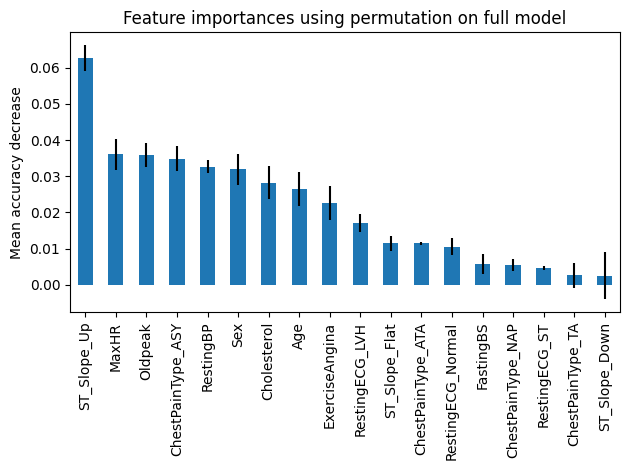

In [72]:
from sklearn.inspection import permutation_importance

clf = RandomForestClassifier(random_state=111, max_depth=8, max_features='sqrt', n_estimators=300)
clf.fit(X,y)
result = permutation_importance(
    clf, X, y, n_repeats=100, random_state=111, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Let's use only the first 10 features with the most influence, and see if we can achieve similar predictive accuracy as before using nested cross validation:

In [65]:
X_reduced = X[forest_importances[0:10].index]

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [5, 8, 10],
}

best_params = []
best_scores = []
best_pred_scores = []

outer_cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=111)

for train, test in outer_cv.split(X_reduced, y):
    X_train, y_train = X_reduced.iloc[train, :], y[train]
    X_test, y_test = X_reduced.iloc[test, :], y[test]
    inner_cv = RepeatedKFold(n_repeats=2, n_splits=5, random_state=111)
    clf = RandomForestClassifier(random_state=111)
    grid_search = GridSearchCV(
        estimator=clf, param_grid=param_grid, cv=inner_cv, n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params.append(grid_search.best_params_)
    best_scores.append(grid_search.best_score_)
    clf_fin = grid_search.best_estimator_
    clf_fin.fit(X_train, y_train)
    y_test_pred = clf_fin.predict(X_test)
    best_pred_scores.append(accuracy_score(y_test, y_test_pred))
    
print(
    f"Mean is {np.mean(best_pred_scores)}"
    + "\n"
    + f"Standard deviation is {np.std(best_pred_scores)}"
)

Mean is 0.8651472035794184
Standard deviation is 0.020192391178157295


Similar results are obtained as before, when every feature were used. This suggest, that using only the 10 most influental features does not result in information loss. The hyperparameters for the final model with the most influental features obtained using cross-validation:

In [66]:
# suppress warnings from numpy:
np.seterr(all="ignore")

param_grid = {
    "n_estimators": [1, 10, 50, 100, 200, 300],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [1, 3, 5, 8, 15],
    "min_samples_leaf": [1, 2, 4, 10, 30],
}

clf = RandomForestClassifier(random_state=111)
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=111)
grid_search = GridSearchCV(
    estimator=clf, param_grid=param_grid, cv=cv, n_jobs=-1
)
grid_search.fit(X_reduced, y)
print(f"The best hyperparameters are: {grid_search.best_params_}")
print(f"The best score is: {grid_search.best_score_}")

The best hyperparameters are: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 50}
The best score is: 0.8667704697986578


Although the new model does not give better predictive accuracy, it is less complex as fewer features are involved and also less trees are required to be estimated (n-estimators is 50 instead of 200/300), which decreases the required time for the model to be built. 